In [1]:
#import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")
import modin.pandas as pd
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter('ignore')
# To shift lists
from collections import deque

import tensorflow as tf
from tensorflow import keras

%matplotlib inline


In [2]:

import os
for dirname, _, filenames in os.walk('D:/electro pi  scolership/task3/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


D:/electro pi  scolership/task3/data\combined_data_1.txt
D:/electro pi  scolership/task3/data\combined_data_2.txt
D:/electro pi  scolership/task3/data\combined_data_3.txt
D:/electro pi  scolership/task3/data\combined_data_4.txt
D:/electro pi  scolership/task3/data\movie_titles.csv
D:/electro pi  scolership/task3/data\probe.txt
D:/electro pi  scolership/task3/data\qualifying.txt
D:/electro pi  scolership/task3/data\README


In [5]:
%%time
## coiuld replace with pd.read_csv and dropping NaNs/ : cols ? 

# DataFrame to store all imported data
if not os.path.isfile('data.csv'):
    data = open('data.csv', mode='w')

files = ['D:/electro pi  scolership/task3/data/combined_data_1.txt',
#         '/data/combined_data_2.txt',
#          '/data/combined_data_3.txt',  # read in half of data only for speedup
#          '/data/combined_data_4.txt'
        ]

# Remove the line with movie_id: and add a new column of movie_id
# Combine all data files into a csv file
for file in files:
  print("Opening file: {}".format(file))
  with open(file) as f:
    for line in f:
        line = line.strip()
        if line.endswith(':'):
            movie_id = line.replace(':', '')
        else:
            data.write('movie_id' + ',' + line)
            data.write('\n')
data.close()

# Read all data into a pd dataframe
df = pd.read_csv('data.csv', names=['movie_id', 'user_id','rating','date'])
print(df.nunique())
df

Opening file: D:/electro pi  scolership/task3/data/combined_data_1.txt


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.scheduler - WARNING - Communication with worker tcp://127.0.0.1:61564 failed during replication: CommClosedError: in <TCP (closed) ConnectionPool.gather local=tcp://127.0.0.1:61651 remote=tcp://127.0.0.1:61564>: ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
distributed.core - ERROR - Exception while handling op scatter
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\distributed\core.py", line 541, in handle_comm
    result = await result
  File "C:\ProgramData\Anaconda3\lib\site-packages\distributed\scheduler.py", line 5904, in scatter
    await self.replicate(keys=keys, workers=workers, n=n)
  File "C:\ProgramData\Anaconda3\lib\site-packages\distributed\scheduler.py", line 6701, in replicate
    for ws in random.sample(tuple(workers - ts._who_has), count):
  File "C:\ProgramData\Anaconda3\lib\random.py", li

ValueError: Sample larger than population or is negative

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


In [6]:
df.head(20)

,movie_id,user_id,rating,date
0,movie_id,1:,NaN,NaN
1,movie_id,1488844,3.0,2005-09-06
2,movie_id,822109,5.0,2005-05-13
3,movie_id,885013,4.0,2005-10-19
4,movie_id,30878,4.0,2005-12-26
5,movie_id,823519,3.0,2004-05-03
6,movie_id,893988,3.0,2005-11-17
7,movie_id,124105,4.0,2004-08-05
8,movie_id,1248029,3.0,2004-04-22
9,movie_id,1842128,4.0,2004-05-09


Note: It took a lot of time while running and Waste alot of Memory usage, because of the very large data size, so I try to find a way to optimize the size of the data.

In [22]:
def reduce_size(df):
    
    start = df.memory_usage().sum() / 1024**2
    print('Memory usage is {:.2f} MB'.format(start))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end = df.memory_usage().sum() / 1024**2
    print('After optimization is: {:.2f} MB'.format(end))
    
    
    return df



In [23]:
def data_loading(file , names , usecols = [0,1] , spe = ' ' , header = False):
    
    df = pd.read_csv(file, names=names, usecols = usecols)
    df = reduce_size(df)
    return df
df1 = data_loading('D:/electro pi  scolership/task3/data/combined_data_1.txt' , ['move_id','user_id','rating','date']  )

Memory usage is 367.10 MB
After optimization is: 209.42 MB


# Data Preprocessing

In [11]:
df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 24053765 entries, 0 to 24053764
Data columns (total 4 columns):
 #   Column    Non-Null Count     Dtype  
---  --------  -----------------  -----  
 0   movie_id  24053765 non-null  object
 1   user_id   24053765 non-null  object
 2   rating    24053764 non-null  float64
 3   date      24053764 non-null  object
dtypes: object(3), float64(1)
memory usage: 734.1 MB


In [14]:
print('number of NaN values in our dataset:', sum(df.isnull().any()))

number of NaN values in our dataset: 2


In [16]:
print('Total Data')
print("-"*80)
print('\nTotal number of rating:', df.shape[0])

Total Data
--------------------------------------------------------------------------------

Total number of rating: 24053765


In [12]:
print('Original Shape: {}'.format(df.shape))

Original Shape: (24053765, 4)


In [9]:
tmp_movies = df[df['rating'].isna()]['user_id'].reset_index()

In [10]:
tmp_movies

,index,user_id
0,0,1:


In [37]:
df['rating'].isnull().sum()

1

In [39]:
df = df[pd.notnull(df['rating'])]

In [41]:
df.head(50)

,movie_id,user_id,rating,date
1,movie_id,1488844,3.0,2005-09-06
2,movie_id,822109,5.0,2005-05-13
3,movie_id,885013,4.0,2005-10-19
4,movie_id,30878,4.0,2005-12-26
5,movie_id,823519,3.0,2004-05-03
6,movie_id,893988,3.0,2005-11-17
7,movie_id,124105,4.0,2004-08-05
8,movie_id,1248029,3.0,2004-04-22
9,movie_id,1842128,4.0,2004-05-09
10,movie_id,2238063,3.0,2005-05-11


In [10]:
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]
movie_indices

[[0, 1],
 [548, 2],
 [694, 3],
 [2707, 4],
 [2850, 5],
 [3991, 6],
 [5011, 7],
 [5105, 8],
 [20016, 9],
 [20112, 10],
 [20362, 11],
 [20561, 12],
 [21108, 13],
 [21234, 14],
 [21353, 15],
 [21644, 16],
 [24344, 17],
 [31453, 18],
 [42176, 19],
 [42716, 20],
 [42833, 21],
 [43052, 22],
 [43256, 23],
 [43872, 24],
 [45206, 25],
 [46414, 26],
 [52276, 27],
 [52550, 28],
 [92303, 29],
 [92827, 30],
 [211241, 31],
 [211463, 32],
 [213318, 33],
 [220209, 34],
 [220318, 35],
 [221158, 36],
 [222098, 37],
 [222380, 38],
 [223183, 39],
 [223936, 40],
 [224428, 41],
 [224522, 42],
 [224651, 43],
 [224757, 44],
 [233259, 45],
 [235879, 46],
 [242438, 47],
 [244789, 48],
 [248381, 49],
 [248613, 50],
 [248942, 51],
 [249033, 52],
 [254181, 53],
 [254296, 54],
 [254456, 55],
 [256863, 56],
 [258697, 57],
 [262260, 58],
 [279666, 59],
 [279871, 60],
 [280167, 61],
 [280315, 62],
 [280606, 63],
 [280791, 64],
 [280887, 65],
 [281146, 66],
 [281313, 67],
 [281603, 68],
 [283820, 69],
 [283937, 70],
 [

In [11]:
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices

deque([[0, 1],
       [548, 2],
       [694, 3],
       [2707, 4],
       [2850, 5],
       [3991, 6],
       [5011, 7],
       [5105, 8],
       [20016, 9],
       [20112, 10],
       [20362, 11],
       [20561, 12],
       [21108, 13],
       [21234, 14],
       [21353, 15],
       [21644, 16],
       [24344, 17],
       [31453, 18],
       [42176, 19],
       [42716, 20],
       [42833, 21],
       [43052, 22],
       [43256, 23],
       [43872, 24],
       [45206, 25],
       [46414, 26],
       [52276, 27],
       [52550, 28],
       [92303, 29],
       [92827, 30],
       [211241, 31],
       [211463, 32],
       [213318, 33],
       [220209, 34],
       [220318, 35],
       [221158, 36],
       [222098, 37],
       [222380, 38],
       [223183, 39],
       [223936, 40],
       [224428, 41],
       [224522, 42],
       [224651, 43],
       [224757, 44],
       [233259, 45],
       [235879, 46],
       [242438, 47],
       [244789, 48],
       [248381, 49],
       [248613, 50],
  

# Data viewing

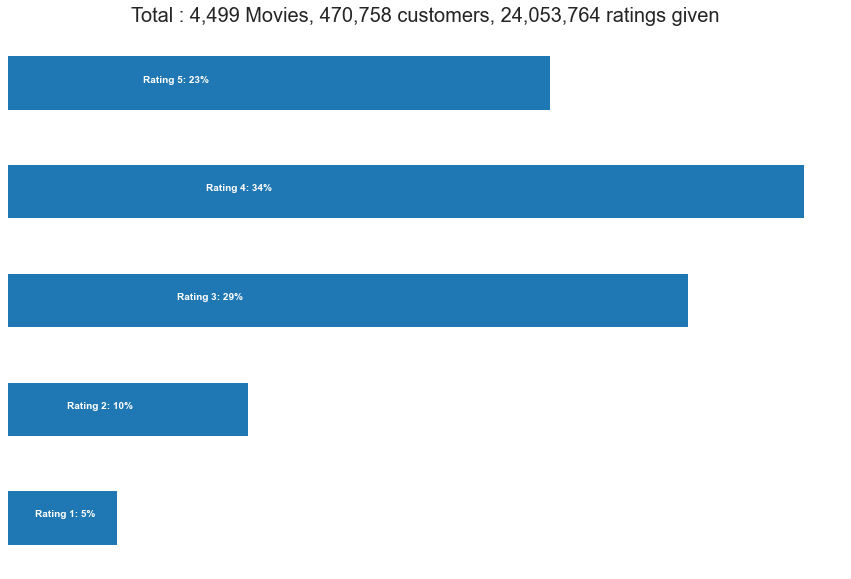

In [12]:
p = df.groupby('rating')['rating'].agg(['count'])

# get movie count
movie_count = df1.isnull().sum()[1]

# get customer count
cust_count = df['user_id'].nunique() - movie_count

# get rating count
rating_count = df['user_id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total : {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [13]:
# create a data frame with index of movie id rows
df_nan = pd.DataFrame(pd.isnull(df1.rating))
df_nan = df_nan[df_nan['rating'] == True]
df_nan = df_nan.reset_index()
print(df_nan.head())

   index  rating
0      0    True
1    548    True
2    694    True
3   2707    True
4   2850    True


In [14]:
# scratch line just for understanding creating the required iteration conditions
temp = np.full((1,5), 1)
print(temp)
movie_np = []
movie_id =1 
for i,j in zip(df_nan['index'][1:],df_nan['index'][:2]):
    print(i)
    print(j)
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    print(temp)
    movie_np = np.append(movie_np, temp)
    print(len(temp[0]))
    movie_id += 1

[[1 1 1 1 1]]
548
0
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 

# Data cleaning

In [15]:
movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df1) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [ ]:
f = ['count','mean']

df_movie_summary = df.groupby('movie_id')['rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('user_id')['rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

# load movie titles File

In [19]:
# Load data for all movies
movie_titles = pd.read_csv('D:/electro pi  scolership/task3/data/movie_titles.csv', error_bad_lines=False, encoding = 'ISO-8859-1', header = None, names = ['Id', 'Year', 'Name']).set_index('Id') 
    
# we need header=None because the first row of the csv file is not header but actual data 
                           
                           



In [20]:
movie_titles.head(50)

,Year,Name
Id,,
1,2003,Dinosaur Planet
2,2004,Isle of Man TT 2004 Review
3,1997,Character
4,1994,Paula Abdul's Get Up & Dance
5,2004,The Rise and Fall of ECW
6,1997,Sick
7,1992,8 Man
8,2004,What the #$*! Do We Know!?
9,1991,Class of Nuke 'Em High 2


In [21]:
print('Shape Movie-Titles:\t{}'.format(movie_titles.shape))

Shape Movie-Titles:	(17434, 2)


In [50]:
movie_titles.describe()

,Year
count,17427.000000
mean,1990.295633
std,16.489299
min,1896.000000
25%,1985.000000
50%,1997.000000
75%,2002.000000
max,2005.000000


In [51]:
movie_titles.loc[movie_titles['Year'].isnull()]

,Year,Name
Id,,
4388,NaN,Ancient Civilizations: Rome and Pompeii
4794,NaN,Ancient Civilizations: Land of the Pharaohs
7241,NaN,Ancient Civilizations: Athens and Greece
10782,NaN,Roti Kapada Aur Makaan
15918,NaN,Hote Hote Pyaar Ho Gaya
16678,NaN,Jimmy Hollywood
17667,NaN,Eros Dance Dhamaka


In [52]:
movies_dict = {'Eros Dance Dhamaka':1999,
               'Jimmy Hollywood':1994,
               'Hote Hote Pyaar Ho Gaya' :1999,
               'Roti Kapada Aur Makaan':1974,
               'Ancient Civilizations: Athens and Greece':1994,
               'Ancient Civilizations: Land of the Pharaohs':1995,
               'Ancient Civilizations: Rome and Pompeii':2014}
for key ,value in  zip(movies_dict.keys() , movies_dict.values()):
    movie_titles.loc[movie_titles['Name']== key , 'Year'] = value
movie_titles.loc[movie_titles['Year'].isnull()]

,Year,Name


In [53]:
movie_titles.info()

<class 'modin.pandas.dataframe.DataFrame'>
Int64Index: 17434 entries, 1 to 17770
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    17434 non-null  float64
 1   Name    17434 non-null  object
dtypes: float64(1), object(1)
memory usage: 924.6 KB


In [54]:
movie_titles['Year'].max()

2014.0

In [56]:
movie_titles.head(50)

,Year,Name
Id,,
1,2003,Dinosaur Planet
2,2004,Isle of Man TT 2004 Review
3,1997,Character
4,1994,Paula Abdul's Get Up & Dance
5,2004,The Rise and Fall of ECW
6,1997,Sick
7,1992,8 Man
8,2004,What the #$*! Do We Know!?
9,1991,Class of Nuke 'Em High 2


# EDA

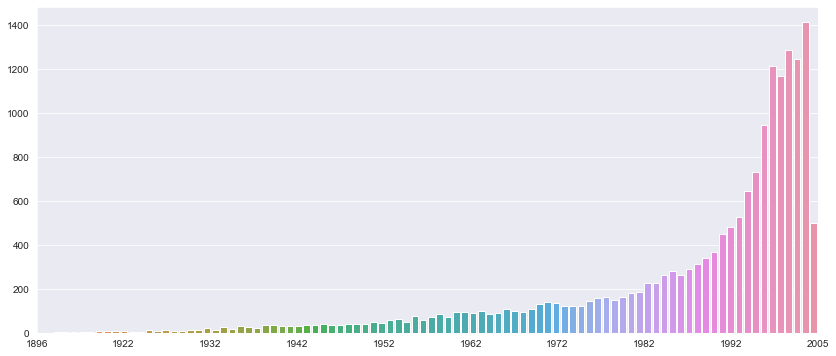

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

data = movie_titles['Year'].value_counts().sort_index()
x = data.index.map(int)
y = data.values

sns.barplot(x, y)
xmin, xmax = plt.xlim()
xtick_labels = [x[0]] + list(x[10:-10:10]) + [x[-1]]
plt.xticks(ticks=np.linspace(xmin, xmax, 10), labels=xtick_labels);

del fig, ax, data, x, y, xmin, xmax, xtick_labels

distribution of ratings

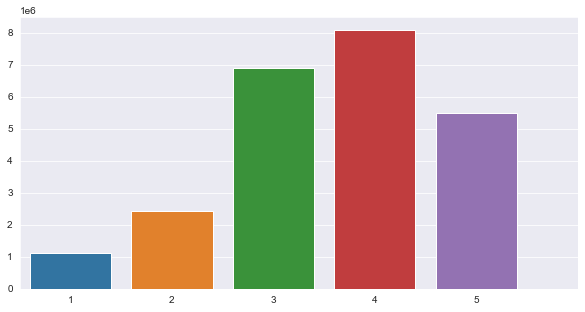

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

data = df['rating'].value_counts().sort_index()
x = data.index.map(int)
y = data.values

sns.barplot(x, y)
xmin, xmax = plt.xlim()
plt.xticks(ticks=[0,1,2,3,4,5]);

del fig, ax, data, x, y, xmin, xmax

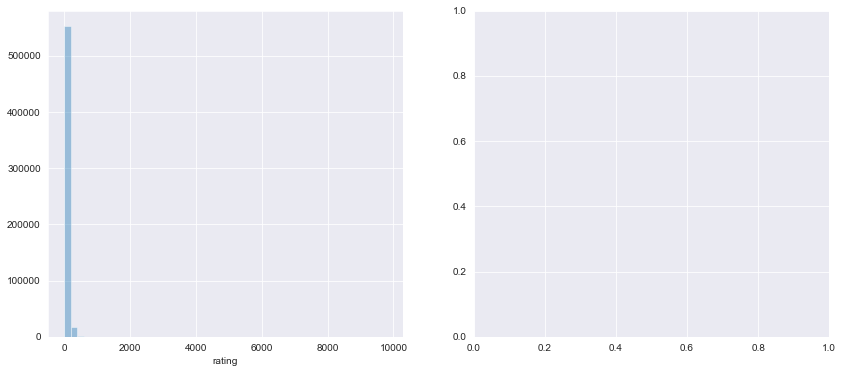

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

data = df.groupby('user_id')['rating'].count()
sns.distplot(data[data  < 10000], kde=False, ax=ax[0], bins=[i for i in range(0,10000,200)]);
sns.distplot(data[data  > 10000], kde=False, ax=ax[1], bins=[i for i in range(10000,150000,5000)]);

del fig, ax, data

In [32]:
# piovt the data since most algorithms need data as sparse matrix, this will be used in Pearson's R correlation method, and SVD
# pivoting only first 100000 rows due to system memory constraints
df_p = pd.pivot_table(df[:100000],values='rating',index='user_id',columns='movie_id')

print(df_p.shape)
print(df_p.head())

(81489, 1)
movie_id  movie_id
user_id           
100006         3.0
1000079        2.0
1000105        4.0
1000158        3.0
1000192        2.0


In [44]:
len(movie_titles['Year'].unique())

95

In [46]:
movie_titles['Year'].max()-movie_titles['Year'].min()

109.0

In [57]:
avg_movies_rating = df.groupby('movie_id')['rating'].agg(['count','mean']).sort_values(ascending=False , by='mean')
avg_movies_rating.max()
avg_movies_rating[0:20]

,count,mean
movie_id,,
movie_id,24053764,3.599634


# """
to predict the top 10 movies realted to a particular movie so that we can recommend movies based on movie that has been 
watched by the customer.
"""

In [78]:
reader = Reader()
# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['user_id', 'movie_id', 'rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

distributed.core - ERROR - Exception while handling op scatter
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\distributed\core.py", line 541, in handle_comm
    result = await result
  File "C:\ProgramData\Anaconda3\lib\site-packages\distributed\scheduler.py", line 5889, in scatter
    raise TimeoutError("No valid workers found")
asyncio.exceptions.TimeoutError: No valid workers found


TimeoutError: No valid workers found

In [68]:
df_785314 = df[(df['user_id'] == 785314) & (df['rating'] == 5)]
df_785314 = df_785314.set_index('movie_id')
df_785314 = df_785314.join(movie_titles)['Name']
print(df_785314)

TypeError: '<' not supported between instances of 'str' and 'int'

predict which movies user 785314 would love to watch:

In [80]:
user_785314 = movie_titles.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['movie_id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['movie_id', 'user_id','rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['movie_id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('movie_id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

distributed.core - ERROR - Exception while handling op scatter
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\distributed\core.py", line 541, in handle_comm
    result = await result
  File "C:\ProgramData\Anaconda3\lib\site-packages\distributed\scheduler.py", line 5889, in scatter
    raise TimeoutError("No valid workers found")
asyncio.exceptions.TimeoutError: No valid workers found


TimeoutError: No valid workers found

# Recommend with Pearsons' R correlations¶

In [64]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(movie_titles.index[movie_titles['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [65]:
recommend("X2: X-Men United", 0)

For movie (X2: X-Men United)
- Top 10 movies recommended based on Pearsons'R correlation - 


KeyError: '191'